In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [ ]:
#xl_to_date = lambda x: pd.to_datetime(x, unit='D', origin='1899-12-30')
#pd.to_datetime(format=)
df = pd.read_csv('redfin_2025-05-14-10-47-02.csv', dtype={'beds':'Int32', 'price':'Int64', 'sf':'Int64', 'lot_sf':'Int64', 'yr_built':'Int32', 'zip':'Int32', }, parse_dates=['sold_date'])  #, converters={'PERIOD_BEGIN': xl_to_date, 'PERIOD_END': xl_to_date})

In [48]:
df.head(2)

,sale_type,sold_date,property_type,price,beds,baths,sf,lot_sf,yr_built,ppsf,address,nhood,zip,city,state,latitude,longitude,url
0,PAST SALE,2024-11-08,SFH,235000,2,1.5,1070,2439,1900,220.0,506 Edmond St,Bloomfield,15224,Bloomfield,PA,40.460372,-79.948827,https://www.redfin.com/PA/Pittsburgh/506-Edmon...
1,PAST SALE,2024-05-28,SFH,210000,3,1.0,1200,426,1900,175.0,3732 Woolslayer Way,Lawrenceville,15201,Lawrenceville,PA,40.464019,-79.961631,https://www.redfin.com/PA/Pittsburgh/3732-Wool...


In [54]:
df[df.property_type == 'SFH'].iloc[1]

sale_type                                                PAST SALE
sold_date                                      2024-05-28 00:00:00
property_type                                                  SFH
price                                                       210000
beds                                                             3
baths                                                          1.0
sf                                                            1200
lot_sf                                                         426
yr_built                                                      1900
ppsf                                                         175.0
address                                        3732 Woolslayer Way
nhood                                                Lawrenceville
zip                                                          15201
city                                                 Lawrenceville
state                                                         

In [55]:
df.dtypes

sale_type                object
sold_date        datetime64[ns]
property_type            object
price                     Int64
beds                      Int32
baths                   float64
sf                        Int32
lot_sf                    Int64
yr_built                  Int32
ppsf                    float64
address                  object
nhood                    object
zip                       Int32
city                     object
state                    object
latitude                float64
longitude               float64
url                      object
dtype: object

In [131]:
#df.describe(exclude=[object]).style
number_cols = df.select_dtypes(['float', 'Int64', 'Int32']).columns
no_decimal = df.select_dtypes(['Int64']).columns  # ['price', 'beds', 'sf', 'lot_sf',]
no_decimal_no_comma = df.select_dtypes(['Int32']).columns  # ['yr_built', 'zip', ]
decimal2_comma = ['ppsf', ]
decimal1_comma = ['baths', ]

def pdpp(df, styler: pd.io.formats.style.Styler=None, *args, **kwargs):    
    if styler is None:
        styler = df.style
    styler.set_table_styles([{'selector': '*', 'props': 'font-family: serif'}])
    styler\
        .format(subset=number_cols, precision=0, thousands=',', decimal='.')\
        .format(subset=no_decimal_no_comma, precision=0, thousands='')\
        .format(subset=decimal2_comma, precision=2, thousands=',', decimal='.')\
        .format(subset=decimal1_comma, precision=1, thousands=',', decimal='.')
    props='''
        //color: #ff0022; 
        //font-size: 4em'''
    styler.map(lambda x: props)
    return df

def dfpp(df: pd.DataFrame, *args, **kwargs):    
    props='''
        //color: #ff0022; 
        //font-size: 4em'''
    
    out_styler = (  df.style.map(lambda x: 'font-family: Arial Narrow; color: auto')  # styler.set_table_styles([{'selector': '*', 'props': 'font-family: serif'}])  # style.set_table_styles([{'selector': '*', 'props': 'font-family: serif'}])
                        .map(lambda x: props)
                        .format(subset=number_cols, precision=0, thousands=',', decimal='.')
                        .format(subset=no_decimal_no_comma, precision=0, thousands='')
                        .format(subset=decimal2_comma, precision=2, thousands=',', decimal='.')
                        .format(subset=decimal1_comma, precision=1, thousands=',', decimal='.')
                        .apply_index(lambda x: ['font-family: Arial Narrow; color: red']*x.shape[0], axis='index')
                        .apply_index(lambda x: ['font-family: Arial Narrow; color: green']*x.shape[0], axis='columns'))

    return out_styler


#df_styled = df.pipe(pdpp)
#df_styled.head(1)
df.head(1).pipe(dfpp)

,sale_type,sold_date,property_type,price,beds,baths,sf,lot_sf,yr_built,ppsf,address,nhood,zip,city,state,latitude,longitude,url
0,PAST SALE,2024-11-08 00:00:00,SFH,"235,000",2,1.5,1070,"2,439",1900,220.00,506 Edmond St,Bloomfield,15224,Bloomfield,PA,40,-80,https://www.redfin.com/PA/Pittsburgh/506-Edmond-St-15224/home/74661264


In [129]:
df.head(1)

,sale_type,sold_date,property_type,price,beds,baths,sf,lot_sf,yr_built,ppsf,address,nhood,zip,city,state,latitude,longitude,url
0,PAST SALE,2024-11-08,SFH,235000,2,1.5,1070,2439,1900,220.0,506 Edmond St,Bloomfield,15224,Bloomfield,PA,40.460372,-79.948827,https://www.redfin.com/PA/Pittsburgh/506-Edmon...


In [35]:
data = df[(df.year >= 2024)&(df.property_type=="SFH")]  # &(df.region=="Bloomfield")

In [36]:
data.describe()

,year,month,median_sale_price,median_sale_price_mom,median_list_price_mom,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list
count,798.000000,798.000000,7.980000e+02,765.000000,696.000000,797.000000,731.000000,798.000000,759.000000,732.000000,725.000000,798.000000,797.000000,798.000000
mean,2024.132832,5.842105,3.016703e+05,0.053029,0.047153,176.942919,187.585268,18.022556,22.169960,24.566940,25.564138,75.049499,0.980393,0.286054
std,0.339606,3.621715,1.897036e+05,0.369560,0.368309,74.092378,76.793242,40.167928,48.224151,52.961175,53.626835,53.927472,0.082081,0.261360
min,2024.000000,1.000000,1.000000e+04,-0.851475,-0.702811,5.291005,19.339990,1.000000,1.000000,1.000000,1.000000,1.000000,0.502513,0.000000
25%,2024.000000,2.000000,1.729150e+05,-0.054545,-0.040360,123.809524,132.379033,2.000000,3.000000,4.000000,4.000000,47.000000,0.953835,0.076923
50%,2024.000000,6.000000,2.575000e+05,0.000000,0.000000,173.708920,182.491944,7.000000,9.000000,10.000000,11.000000,57.500000,0.976582,0.250000
75%,2024.000000,9.000000,3.793750e+05,0.073333,0.082913,229.135958,232.362822,14.000000,17.000000,18.250000,19.000000,91.500000,1.004029,0.411765
max,2025.000000,12.000000,1.125000e+06,5.663333,6.996000,371.912037,561.523438,265.000000,295.000000,343.000000,316.000000,565.000000,1.775517,1.000000


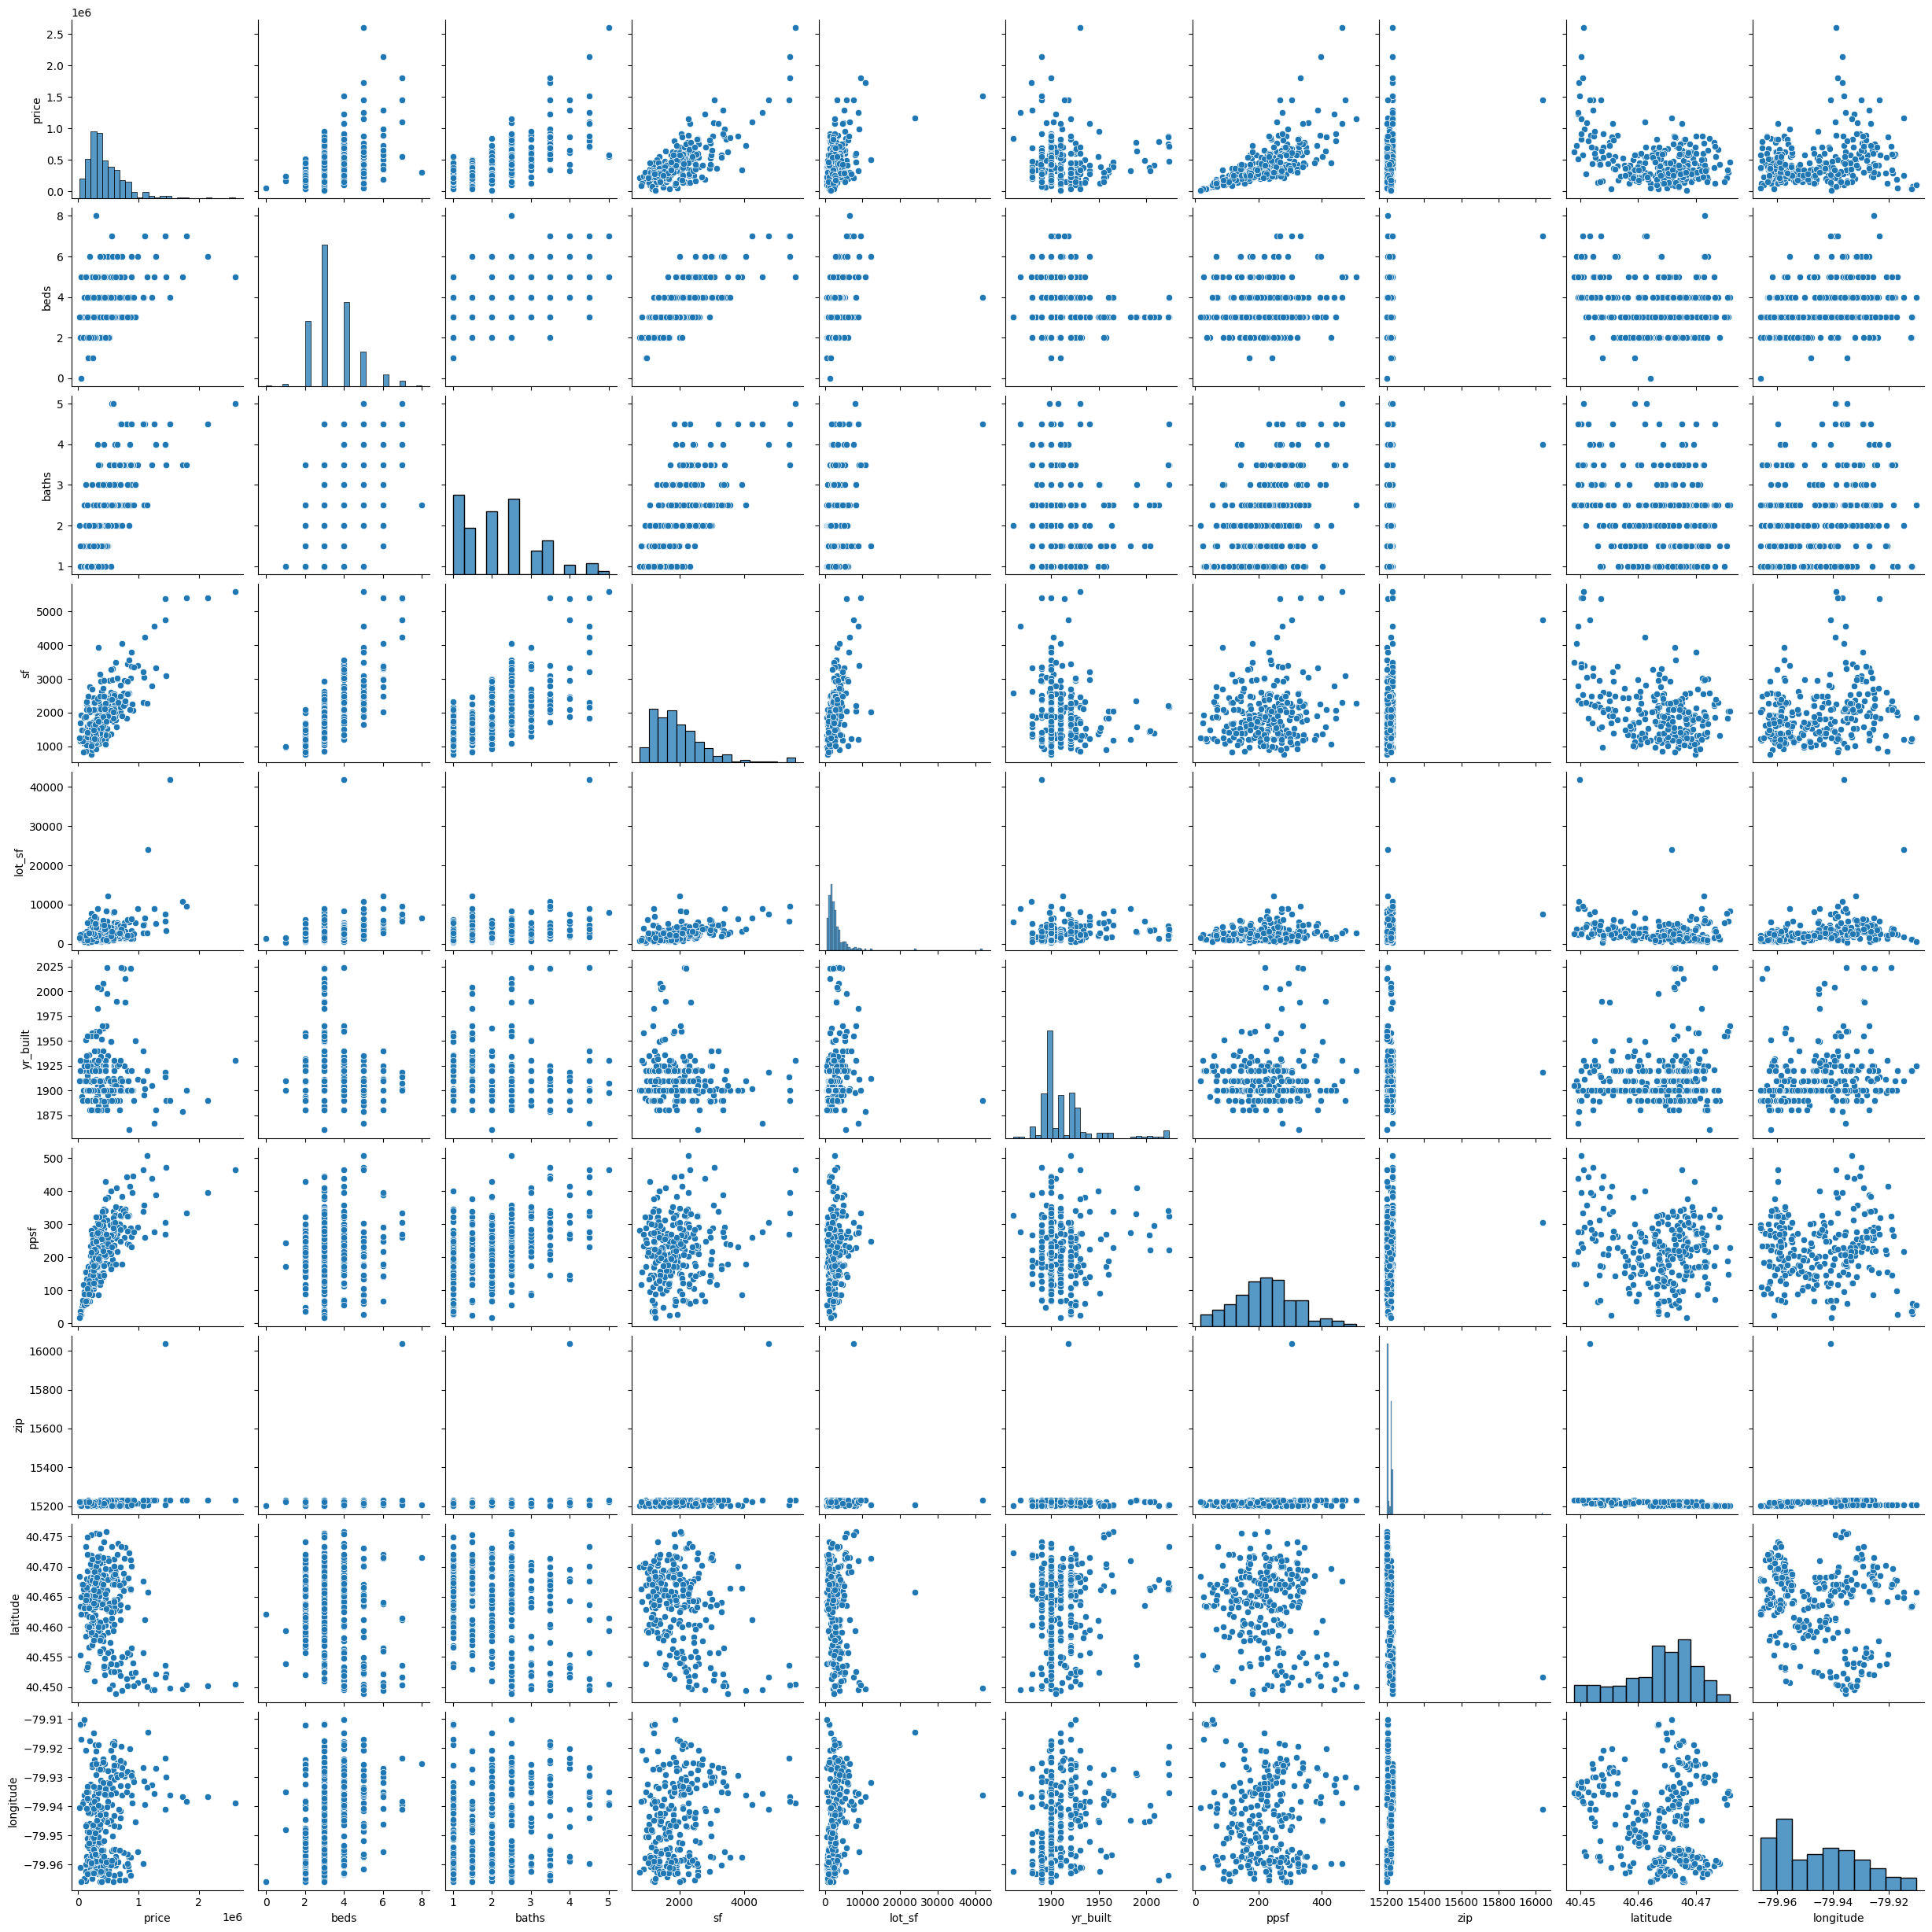

In [24]:
sns.pairplot(df)